In [2]:
import numpy as np 
import pandas as pd
import pandas_datareader as dr
import yfinance as yf

from pylab import plot,show
from matplotlib import pyplot as plt
import plotly.express as px

from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn.cluster import KMeans 
from sklearn import preprocessing

In [3]:
import yfinance as yf
import pandas as pd
import time
from math import sqrt

# Define the url
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]
tickers = [s.replace(' ', '') for s in tickers]

# Download prices
prices_list = []
for ticker in tickers:
    try:
        prices = yf.download(ticker, start="2020-01-01")['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
        time.sleep(0.5)  # Delay to avoid hitting rate limits
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Concatenate only if there is data in prices_list
if prices_list:
    prices_df = pd.concat(prices_list, axis=1)
    prices_df.sort_index(inplace=True)
else:
    print("No data was retrieved for any tickers.")

# Create an empty dataframe for returns
returns = pd.DataFrame()

# Define the column Returns if prices_df is populated
if not prices_df.empty:
    # Calculate Returns and Volatility
    returns['Returns'] = prices_df.pct_change().mean() * 252
    returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
else:
    print("prices_df is empty; no returns or volatility data available.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
print("Returns data:")
print(returns.head())
print("\nChecking for NaN values in Returns and Volatility columns:")
print(returns.isna().sum())

returns = returns.dropna()



Returns data:
       Returns  Volatility
MMM   0.050629    0.297429
AOS   0.160851    0.305526
ABT   0.110145    0.264077
ABBV  0.242316    0.242532
ACN   0.163471    0.295062

Checking for NaN values in Returns and Volatility columns:
Returns       2
Volatility    2
dtype: int64


C:\Users\local_srb019\Temp\ipykernel_15480\2982810007.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data = torch.tensor([returns['Returns'].values, returns['Volatility'].values], dtype=torch.float32).T.to('cuda')


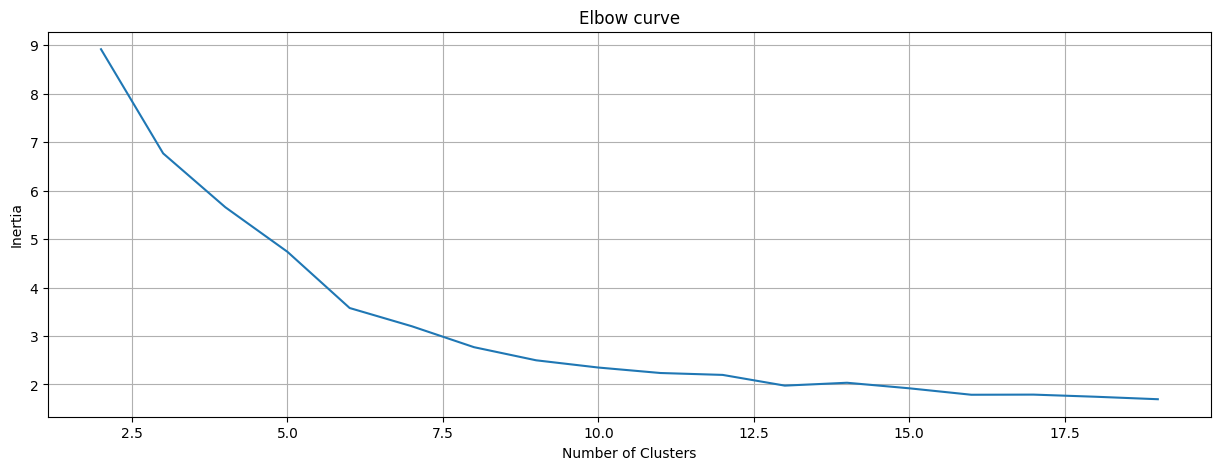

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Format the data as a PyTorch tensor and move it to GPU
data = torch.tensor([returns['Returns'].values, returns['Volatility'].values], dtype=torch.float32).T.to('cuda')
X = data

def kmeans(X, k, num_iterations=100):
    # Randomly initialize cluster centers
    centers = X[torch.randperm(X.size(0))[:k]].clone()
    for i in range(num_iterations):
        # Assign clusters based on closest center
        distances = torch.cdist(X, centers)
        labels = distances.argmin(dim=1)
        
        # Update cluster centers as mean of assigned points
        new_centers = torch.stack([X[labels == j].mean(dim=0) for j in range(k)])
        
        # Check for convergence (optional)
        if torch.all(centers == new_centers):
            break
        centers = new_centers
    
    # Compute inertia
    inertia = (torch.cdist(X, centers).min(dim=1).values ** 2).sum().item()
    return inertia

# Run the GPU-accelerated K-Means and calculate distortions
distorsions = []
for k in range(2, 20):
    inertia = kmeans(X, k)
    distorsions.append(inertia)

# Plot the Elbow curve
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [6]:
def kmeans(X, k, num_iterations=100):
    centers = X[torch.randperm(X.size(0))[:k]].clone()  # Initialize cluster centers
    for i in range(num_iterations):
        # Compute distances and assign clusters
        distances = torch.cdist(X, centers)
        labels = distances.argmin(dim=1)
        
        # Update cluster centers
        new_centers = torch.stack([X[labels == j].mean(dim=0) if (labels == j).any() else centers[j] for j in range(k)])
        
        # Check for convergence
        if torch.allclose(centers, new_centers, atol=1e-6):
            break
        centers = new_centers
    
    # Calculate inertia
    inertia = (torch.cdist(X, centers).min(dim=1).values ** 2).sum().item()
    
    return centers, inertia  # Return both centers and inertia


In [7]:
# Run K-Means with K = 4
k = 4
num_iterations = 100
centroids, _ = kmeans(data, k, num_iterations)

# Assign each sample to the nearest cluster center
distances = torch.cdist(data, centroids)  # Calculate distances between points and centroids
idx = distances.argmin(dim=1).cpu()       # Closest centroid index for each point

# Create a dataframe with tickers and their assigned clusters
details_df = pd.DataFrame({'Ticker': returns.index, 'Cluster': idx.numpy()})

# Merge cluster information directly into the returns DataFrame
clusters_df = returns.copy().reset_index()
clusters_df['Cluster'] = details_df['Cluster']

# Final DataFrame with the cluster assignments
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']
print(clusters_df.head())


  Ticker   Returns  Volatility  Cluster
0    MMM  0.050629    0.297429        1
1    AOS  0.160851    0.305526        2
2    ABT  0.110145    0.264077        1
3   ABBV  0.242316    0.242532        2
4    ACN  0.163471    0.295062        2


In [8]:
import plotly.express as px
import nbformat as nbf
# Ensure 'Cluster' column is of integer type for proper color grouping
clusters_df['Cluster'] = clusters_df['Cluster'].astype(int)

# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update_layout(coloraxis_showscale=False)  # Hide color scale if not needed
fig.show()


In [10]:
# Identify and remove the outliers stocks
returns.drop('GEV',inplace=True)
returns.drop('AMTM',inplace=True)


# Recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

In [12]:
import plotly.express as px

# Convert the updated `returns` DataFrame to a PyTorch tensor
data = torch.tensor([returns['Returns'].values, returns['Volatility'].values], dtype=torch.float32).T.to('cuda')

# Run K-Means with K = 4 on the updated data
k = 4
num_iterations = 100
centroids, _ = kmeans(data, k, num_iterations)

# Assign each sample to the nearest cluster center
distances = torch.cdist(data, centroids)  # Calculate distances between points and centroids
idx = distances.argmin(dim=1).cpu()       # Closest centroid index for each point

# Create a dataframe with tickers and their assigned clusters
details_df = pd.DataFrame({'Ticker': returns.index, 'Cluster': idx.numpy()})

# Merge cluster information directly into the returns DataFrame
clusters_df = returns.reset_index()
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

# Ensure 'Cluster' column is of integer type for proper color grouping
clusters_df['Cluster'] = clusters_df['Cluster'].astype(int)

# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update_layout(coloraxis_showscale=False)  # Hide color scale if not needed
fig.show()



In [13]:
# Download trailingPE and dividendRate 
trailingPE_list = []
dividendRate_list = []

for t in tickers:
   
    tick = yf.Ticker(t)
    ticker_info = tick.info

    try:
        trailingPE = ticker_info['trailingPE']
        trailingPE_list.append(trailingPE)
    except:
        trailingPE_list.append('na')

    try:
        dividendRate = ticker_info['dividendRate']
        dividendRate_list.append(dividendRate)
    except:
        dividendRate_list.append('na')

# Create a datafrane to contain the data
sp_features_df = pd.DataFrame()

# Add the ticker, trailingPE and dividendRate data
sp_features_df['Ticker'] = tickers
sp_features_df['trailingPE'] = trailingPE_list
sp_features_df['dividendRate'] = dividendRate_list

# Shares with 'na' as dividend rate has no dividend so we have to assign 0 as dividend rate in this cases
sp_features_df["dividendRate"] = sp_features_df["dividendRate"].fillna(0)

# filter shares with 'na' as trailingPE 
df_mask = sp_features_df['trailingPE'] != 'na' 
sp_features_df = sp_features_df[df_mask]

# Convert trailingPE numbers to float type
sp_features_df['trailingPE'] = sp_features_df['trailingPE'].astype(float)

# Removes the rows that contains NULL values 
sp_features_df=sp_features_df.dropna()


Data shape: torch.Size([387, 2])
Sample data: tensor([[13.3510,  2.8000],
        [20.0897,  1.3600],
        [34.8237,  2.2000],
        [67.2341,  6.2000],
        [30.4288,  5.9200]], device='cuda:0')


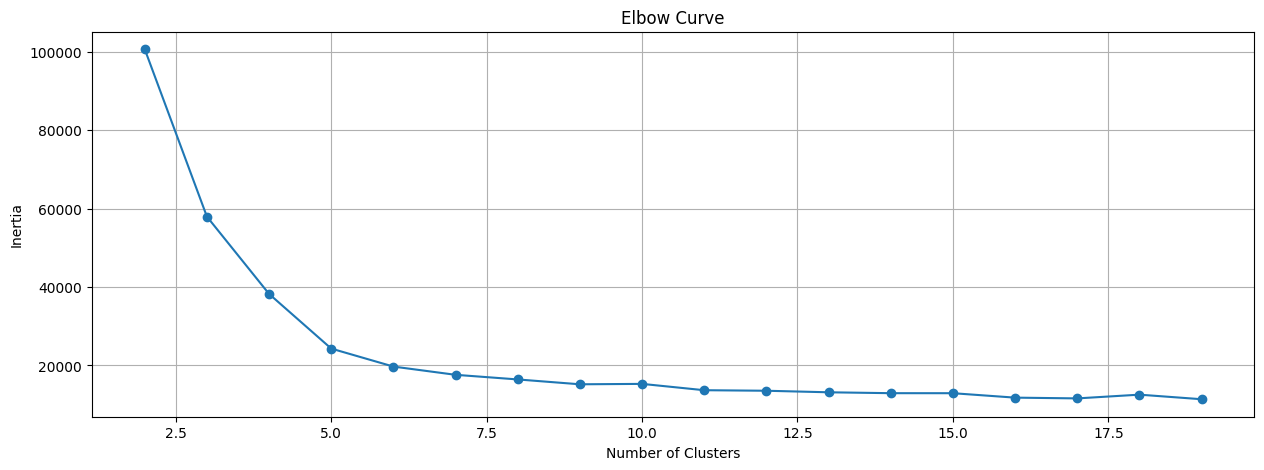

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Replace infinite values with NaN and drop them
sp_features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sp_features_df.dropna(subset=['trailingPE', 'dividendRate'], inplace=True)

# Filter out extremely large values (optional threshold)
threshold = 1e10  # Define a reasonable threshold based on your data
sp_features_df = sp_features_df[(sp_features_df['trailingPE'] < threshold) & (sp_features_df['dividendRate'] < threshold)]

# Convert to PyTorch tensor and move to GPU
data = torch.tensor([sp_features_df['trailingPE'].values, sp_features_df['dividendRate'].values], dtype=torch.float32).T.to('cuda')

# Check the data after cleaning
print("Data shape:", data.shape)
print("Sample data:", data[:5])

# Define K-Means function and plot elbow curve (as per previous code)
def kmeans(X, k, num_iterations=100):
    centers = X[torch.randperm(X.size(0))[:k]].clone()  # Initialize cluster centers
    for i in range(num_iterations):
        distances = torch.cdist(X, centers)
        labels = distances.argmin(dim=1)
        
        # Update cluster centers
        new_centers = torch.stack([X[labels == j].mean(dim=0) if (labels == j).any() else centers[j] for j in range(k)])
        
        if torch.allclose(centers, new_centers, atol=1e-6):  # Convergence check
            break
        centers = new_centers
    
    # Compute inertia as the sum of squared distances to closest center
    inertia = (torch.cdist(X, centers).min(dim=1).values ** 2).sum().item()
    return inertia

# Calculate distortions (inertia) for each k
distorsions = []
for k in range(2, 20):
    inertia = kmeans(data, k)
    distorsions.append(inertia)

# Plot the Elbow curve
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions, marker='o')
plt.grid(True)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()




In [20]:
def kmeans(X, k, num_iterations=100):
    centers = X[torch.randperm(X.size(0))[:k]].clone()  # Randomly initialize cluster centers
    for i in range(num_iterations):
        # Calculate distances and assign clusters
        distances = torch.cdist(X, centers)
        labels = distances.argmin(dim=1)
        
        # Update cluster centers
        new_centers = torch.stack([X[labels == j].mean(dim=0) if (labels == j).any() else centers[j] for j in range(k)])
        
        # Check for convergence
        if torch.allclose(centers, new_centers, atol=1e-6):
            break
        centers = new_centers
    
    # Compute inertia (sum of squared distances to the closest center)
    inertia = (torch.cdist(X, centers).min(dim=1).values ** 2).sum().item()
    return centers, inertia  # Return both centers and inertia


In [21]:


# Run K-Means with K = 3 (3 clusters)
k = 3
centroids, _ = kmeans(data, k)

# Assign each sample to the nearest cluster center
distances = torch.cdist(data, centroids)  # Calculate distances to centroids
idx = distances.argmin(dim=1).cpu()       # Closest centroid index for each point

# Create clusters directly on the GPU
cluster_1 = data[idx == 0].cpu()  # Convert to CPU for compatibility with plotting
cluster_2 = data[idx == 1].cpu()
cluster_3 = data[idx == 2].cpu()

# Create a DataFrame with tickers and their assigned clusters
details_df = pd.DataFrame({'Ticker': sp_features_df.index, 'Cluster': idx.numpy()})

# Merge cluster information directly into sp_features_df
clusters_df = sp_features_df.copy()
clusters_df['Cluster'] = details_df['Cluster'].values

# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="dividendRate", y="trailingPE", color="Cluster", hover_data=["Ticker"])
fig.update_layout(coloraxis_showscale=False)  # Hide color scale if not needed
fig.show()


In [22]:
# Define a mask to filter out outliers based on threshold criteria
df_mask = (sp_features_df['trailingPE'] < 200) & (sp_features_df['dividendRate'] < 5)

# Apply the mask to remove outliers
sp_features_df = sp_features_df[df_mask]


In [25]:

# Prepare the data for K-means by selecting the normalized columns
data = torch.tensor(sp_features_df[['trailingPE_norm', 'dividendRate_norm']].values, dtype=torch.float32).to('cuda')

# Define the K-means function if not already defined
def kmeans(X, k, num_iterations=100):
    centers = X[torch.randperm(X.size(0))[:k]].clone()  # Initialize cluster centers
    for i in range(num_iterations):
        distances = torch.cdist(X, centers)
        labels = distances.argmin(dim=1)
        
        # Update cluster centers
        new_centers = torch.stack([X[labels == j].mean(dim=0) if (labels == j).any() else centers[j] for j in range(k)])
        
        if torch.allclose(centers, new_centers, atol=1e-6):  # Check for convergence
            break
        centers = new_centers
    
    # Compute inertia
    inertia = (torch.cdist(X, centers).min(dim=1).values ** 2).sum().item()
    return centers, inertia  # Return both centers and inertia

# Run K-Means with K = 3 (3 clusters)
k = 3
centroids, _ = kmeans(data, k)

# Assign each sample to the nearest cluster center
distances = torch.cdist(data, centroids)
idx = distances.argmin(dim=1).cpu()  # Closest centroid index for each point

# Create a DataFrame with tickers and their assigned clusters
details_df = pd.DataFrame({'Ticker': sp_features_df.index, 'Cluster': idx.numpy()})

# Merge cluster information directly into sp_features_df
clusters_df = sp_features_df.copy()
clusters_df['Cluster'] = details_df['Cluster'].values

# Plot the clusters using Plotly
fig = px.scatter(clusters_df, x="dividendRate_norm", y="trailingPE_norm", color="Cluster", hover_data=["Ticker"])
fig.update_layout(coloraxis_showscale=False)
fig.show()